## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Быстров Иван Дмитриевич

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    print(y)
    break

[2 8 1 9 1 7 7 2 6 1 8 6 6 6 8 2 2 9 8 0 4 1 9 5 3 2 8 6 7 5 3 8 3 1 6 5 1
 0 1 1 5 6 0 8 7 2 2 1 2 8 8 2 3 3 9 0 7 0 7 3 6 7 6 7 2 3 2 2 7 3 9 7 5 9
 3 6 0 4 7 8 6 5 5 7 6 6 5 8 3 4 5 8 1 7 9 4 2 6 2 8 0 0 2 5 7 6 4 8 6 0 4
 4 1 4 9 7 1 6 8 8 8 0 9 9 3 7 7 7]


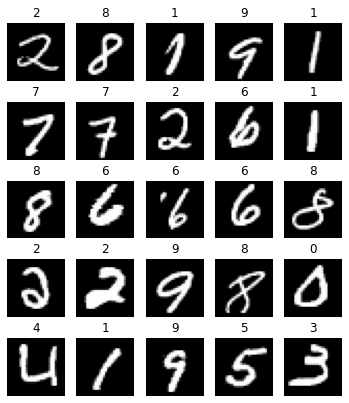

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [6]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    #1 - веса сети
    #2 - нули ...
    #bias = torch.zeros_like(bias)
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

def make_linear(in_dim, out_dim):
    layer = nn.Linear(in_dim, out_dim)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    return layer

# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

In [7]:
def experiment(variant, act_func):
    sizes = [28**2] + [200] * 200 + [10]
    layers = []
    for in_dim, out_dim in zip(sizes, sizes[1:]):
        layer = make_linear(in_dim, out_dim)
        if variant == "dumb":
            init_layer(layer, 0, 0.1)
        elif variant == "xavier":
            init_layer(layer, 0, (2/(in_dim + out_dim))**0.5)
        elif variant == "he":
            init_layer(layer, 0, (2/in_dim)**0.5)
        else:
            raise RuntimeError("invalid variant")
        layers.append(act_func)
        layers.append(layer)
    print("layers ", len(layers))
    network = nn.Sequential(*layers)
    n_objects = 100
    X = images_train[:n_objects].view(n_objects, -1).data
    y = labels_train[:n_objects].data
    activations = network(X)
    loss_fn = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
    loss = loss_fn(activations, y)
    loss.backward()

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [8]:
experiment("dumb", nn.Tanh())

layers  402
forward 0.47820955514907837
forward 0.7200887203216553
forward 0.6266298890113831
forward 0.587513267993927
forward 0.5690940618515015
forward 0.5532349348068237
forward 0.5581330060958862
forward 0.5542468428611755
forward 0.5564238429069519
forward 0.5536251664161682
forward 0.560326874256134
forward 0.5582830309867859
forward 0.5593557357788086
forward 0.5530853867530823
forward 0.5381639003753662
forward 0.5452154874801636
forward 0.53907710313797
forward 0.5418281555175781
forward 0.552696704864502
forward 0.5545133352279663
forward 0.5594236254692078
forward 0.5580471754074097
forward 0.5633972883224487
forward 0.5588468313217163
forward 0.5506985187530518
forward 0.5495293736457825
forward 0.552254855632782
forward 0.5504707098007202
forward 0.5491267442703247
forward 0.552410364151001
forward 0.5484298467636108
forward 0.5489542484283447
forward 0.5482033491134644
forward 0.5440951585769653
forward 0.5481370687484741
forward 0.554069995880127
forward 0.5609590411186

<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [9]:
experiment("xavier", nn.Tanh())

layers  402
forward 0.47820955514907837
forward 0.4899752736091614
forward 0.4045182764530182
forward 0.34815603494644165
forward 0.3118710219860077
forward 0.2924932539463043
forward 0.26623642444610596
forward 0.246590256690979
forward 0.23492442071437836
forward 0.21880842745304108
forward 0.20165853202342987
forward 0.19501350820064545
forward 0.1845284253358841
forward 0.17834386229515076
forward 0.1788918823003769
forward 0.17364142835140228
forward 0.1666562408208847
forward 0.15776574611663818
forward 0.15340104699134827
forward 0.1525329053401947
forward 0.14745831489562988
forward 0.1420498788356781
forward 0.13231463730335236
forward 0.12890705466270447
forward 0.13373245298862457
forward 0.13045090436935425
forward 0.12692959606647491
forward 0.12615114450454712
forward 0.1290690302848816
forward 0.12643058598041534
forward 0.12667524814605713
forward 0.1276521384716034
forward 0.12323366105556488
forward 0.11747689545154572
forward 0.11526723206043243
forward 0.11607848107

In [10]:
experiment("he", nn.Tanh())

layers  402
forward 0.47820955514907837
forward 0.5421890616416931
forward 0.539498507976532
forward 0.5342214703559875
forward 0.5440517663955688
forward 0.5448703169822693
forward 0.5504215955734253
forward 0.5579063892364502
forward 0.5531283020973206
forward 0.5570455193519592
forward 0.5580559968948364
forward 0.5484914779663086
forward 0.5623189806938171
forward 0.5523155927658081
forward 0.549024224281311
forward 0.5491715669631958
forward 0.5440256595611572
forward 0.5464640259742737
forward 0.5474351644515991
forward 0.5442459583282471
forward 0.5538439750671387
forward 0.5541871190071106
forward 0.5607555508613586
forward 0.5553106069564819
forward 0.5519638657569885
forward 0.5450546741485596
forward 0.5522849559783936
forward 0.5505204200744629
forward 0.5544415712356567
forward 0.5608787536621094
forward 0.5597837567329407
forward 0.5569726228713989
forward 0.5594775676727295
forward 0.5537043809890747
forward 0.5571286082267761
forward 0.5602807402610779
forward 0.5556215

In [11]:
experiment("he", nn.ReLU())

layers  402
forward 0.8440015316009521
forward 0.7189444303512573
forward 0.7027269005775452
forward 0.7232218980789185
forward 0.720567524433136
forward 0.7331939339637756
forward 0.7342183589935303
forward 0.7414839863777161
forward 0.6670235395431519
forward 0.6649144887924194
forward 0.601786196231842
forward 0.5416886210441589
forward 0.48462098836898804
forward 0.42931318283081055
forward 0.45719581842422485
forward 0.4836810231208801
forward 0.47110170125961304
forward 0.5143380165100098
forward 0.4757973849773407
forward 0.493813157081604
forward 0.5180529356002808
forward 0.49092918634414673
forward 0.5120370388031006
forward 0.44453516602516174
forward 0.46736228466033936
forward 0.5237812399864197
forward 0.4825763702392578
forward 0.5463323593139648
forward 0.56292724609375
forward 0.5145273208618164
forward 0.5231693983078003
forward 0.4844936430454254
forward 0.5607752799987793
forward 0.5295531153678894
forward 0.4934982359409332
forward 0.559408962726593
forward 0.59681

<i> 1.4 Сделайте выводы по первой части </i>

И he, и xavier позволяют избежать значительных изменений дисперсии, но при этом he хорошо работает с ReLU и плохо - с Tanh.

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [12]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):    
        P = torch.ones_like(self.linear.weight) * (1 - self.p)
        if self.training:          
            #mask = P.bernoulli_()
            mask = torch.bernoulli(P)
        else:
            mask = P
            
        mask = mask.detach()
        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [13]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()    
        
        channels = 1
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),    
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),            
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()
        
        self.final_part = final_part
        
        self.log_softmax = nn.LogSoftmax(1)        
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

In [14]:
def build_layers(mode, drop_con = 0.1, drop_out = 0.2):
    layers = []
    sizes = [196, 128, 128, 10]
    for in_dim, out_dim in zip(sizes, sizes[1:]):
        if mode == "drop_connect":
            layer = DropConnect(in_dim, out_dim, drop_con)
            layers.append(layer)
        else:
            layer = nn.Linear(in_dim, out_dim)
            layers.append(layer)
        if mode == "dropout":
            layers.append(nn.Dropout(drop_out))
        layers.append(nn.ReLU())
    del layers[-1]
    return layers

In [15]:
# %load train_utils.py
import numpy as np
#from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import sys
from IPython.display import clear_output

def _epoch(network, loss, loader,
           backward=True,
           optimizer=None,
           device='cpu',
           ravel_init=False):
    losses = []
    accuracies = []
    for X, y in loader:
        X = X.to(device)
        y = y.to(device)
        if ravel_init:
            X = X.view(X.size(0), -1)
        network.zero_grad()
        prediction = network(X)
        loss_batch = loss(prediction, y)
        losses.append(loss_batch.cpu().item())
        if backward:
            loss_batch.backward()
            optimizer.step()
        prediction = prediction.max(1)[1]
        accuracies.append((prediction==y).cpu().float().numpy().mean())
    return losses, accuracies


def train(network, train_loader, test_loader,
          epochs, learning_rate, ravel_init=False,
          device='cpu', tolerate_keyboard_interrupt=True):
    loss = nn.NLLLoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    network = network.to(device)
    try:
        for epoch in range(epochs):
            network.train()
            losses, accuracies = _epoch(network,
                                        loss,
                                        train_loader,
                                        True,
                                        optimizer,
                                        device,
                                        ravel_init)
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            
            network.eval()
            losses, accuracies = _epoch(network,
                                        loss,
                                        test_loader,
                                        False,
                                        optimizer,
                                        device,
                                        ravel_init)

            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            print('Epoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train accuracy')
            plt.plot(test_accuracy_epochs, label='Test accuracy')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Accuracy', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        if tolerate_keyboard_interrupt:
            pass
        else:
            raise KeyboardInterrupt
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

Epoch 9... (Train/Test) NLL: 0.040/0.066	Accuracy: 0.986/0.980


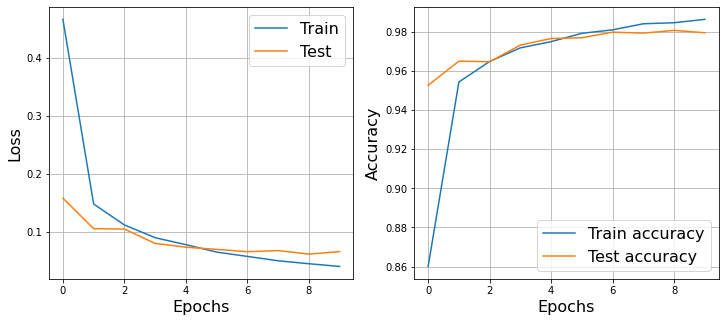

Wall time: 3min 10s


([0.46724391889089206,
  0.14814786254755977,
  0.11193642480525254,
  0.08987753490990857,
  0.07786445144905464,
  0.06502400801431682,
  0.05756215797439376,
  0.05004116195812027,
  0.04491674277419125,
  0.040223930538919914],
 [0.15817603141163725,
  0.10551792125901373,
  0.1048521798198359,
  0.07999356213626982,
  0.07350232764559833,
  0.06971235698548771,
  0.0656715139416577,
  0.06768843733788102,
  0.06151843422882353,
  0.0658572162766764],
 [0.86007464,
  0.95442986,
  0.96491873,
  0.9718928,
  0.9750633,
  0.9793277,
  0.98110455,
  0.98421395,
  0.98474145,
  0.9864684],
 [0.9527294,
  0.965091,
  0.9647943,
  0.973299,
  0.9766614,
  0.977057,
  0.97992486,
  0.9794304,
  0.9808149,
  0.97962815])

In [16]:
%%time
layers1 = build_layers("none")
network = TestNetwork(nn.Sequential(*layers1))
train(network, train_loader, test_loader, 10, 0.001, device='cpu')

Epoch 9... (Train/Test) NLL: 0.047/0.054	Accuracy: 0.985/0.983


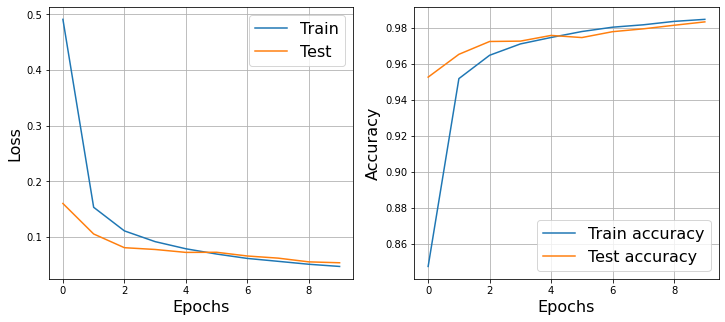

Wall time: 3min 17s


([0.49100124217998753,
  0.15359486185951526,
  0.11122822468437112,
  0.09193694769645105,
  0.07912009396254699,
  0.06965923173897175,
  0.061778601396010754,
  0.056586648306763694,
  0.05131346066750443,
  0.04739376835436669],
 [0.16040723884030234,
  0.10567672960931741,
  0.08104957073125281,
  0.07786045911945874,
  0.07261344868265375,
  0.07282724565254595,
  0.06614217510494062,
  0.06232070954681575,
  0.055605944935703956,
  0.05399000386212351],
 [0.84768677,
  0.951909,
  0.9648632,
  0.9711487,
  0.9747357,
  0.97802836,
  0.98043823,
  0.9817653,
  0.98365873,
  0.9847859],
 [0.9527294,
  0.96538764,
  0.9725079,
  0.9727057,
  0.97587025,
  0.9746835,
  0.977947,
  0.97952926,
  0.9815071,
  0.9833861])

In [17]:
%%time
layers1 = build_layers("drop_connect", drop_con=0.03)
network = TestNetwork(nn.Sequential(*layers1))
train(network, train_loader, test_loader, 10, 0.001, device='cpu')

Epoch 9... (Train/Test) NLL: 0.058/0.060	Accuracy: 0.980/0.981


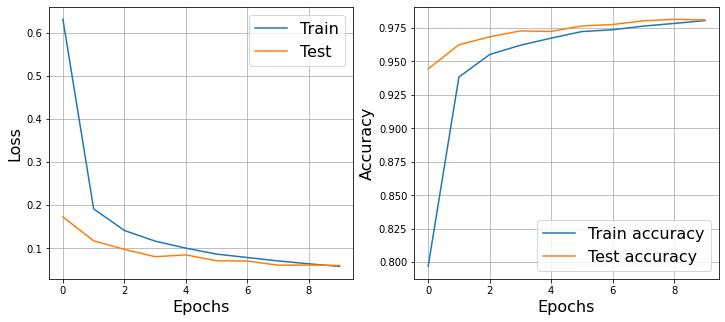

Wall time: 3min 12s


([0.6306362722251715,
  0.19148003437848232,
  0.14142272639662218,
  0.11676480727536338,
  0.10049939873828881,
  0.08664314472662614,
  0.07879689853908474,
  0.07089761369970879,
  0.06416530179570733,
  0.05810199795997759],
 [0.17287870345613623,
  0.117434831406874,
  0.09760010444052235,
  0.08068830877118095,
  0.08487178595100023,
  0.07136471713362616,
  0.07066987045816606,
  0.060977855785690906,
  0.0612864317843997,
  0.06045224664060847],
 [0.7969028,
  0.93832177,
  0.9551184,
  0.9620814,
  0.96737856,
  0.9722981,
  0.9736419,
  0.97637373,
  0.978356,
  0.98045486],
 [0.9444225,
  0.9624209,
  0.9683544,
  0.9728046,
  0.972409,
  0.9764636,
  0.9775514,
  0.9803204,
  0.98140824,
  0.98101264])

In [18]:
%%time
layers1 = build_layers("dropout", drop_out = 0.03)
network = TestNetwork(nn.Sequential(*layers1))
train(network, train_loader, test_loader, 10, 0.001, device='cpu')

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

<i> 2.3 Сделайте выводы по третьей части. </i>

Применение dropconnect и dropout позволило уменьшить итоговый loss и увеличить итоговую accuracy. При этом dropconnect показал результаты лучше, чем dropout.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [19]:
# полезные функции: .std(dim), .mean(dim)
class LayerNormalization(nn.Module):
    def __init__(self, gamma=1, beta=0, eps = 0.00001):
        super().__init__()
        self.gamma = gamma
        self.beta = beta
        self.eps = eps
    def forward(self, x):
        avg = x.mean(axis=1, keepdim = True)
        std = x.std(axis=1, keepdim = True)
        output = self.gamma * (x - avg) / (std + self.eps) + self.beta
        return output

In [20]:
def build_layers_nrm(mode):
    layers = []
    sizes = [196, 128, 128, 10]
    for in_dim, out_dim in zip(sizes, sizes[1:]):
        if mode == "batch":
            layer = nn.Linear(in_dim, out_dim)
            layers.append(layer)
            layers.append(nn.BatchNorm1d(out_dim, affine=False))
            layers.append(nn.ReLU())
        elif mode == "layer":
            layer = nn.Linear(in_dim, out_dim)
            layers.append(layer)
            layers.append(LayerNormalization())
            layers.append(nn.ReLU())
    del layers[-2:]
    return layers

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

Epoch 9... (Train/Test) NLL: 0.020/0.054	Accuracy: 0.994/0.984


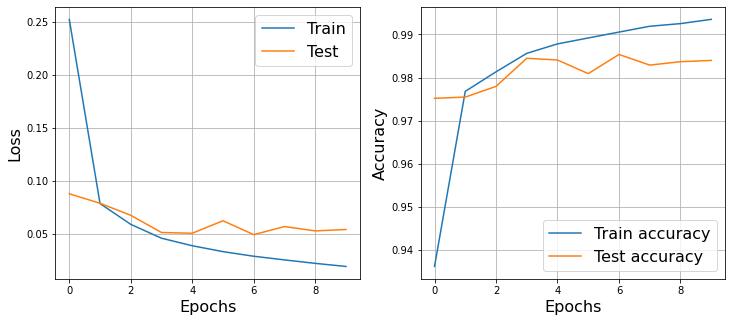

Wall time: 3min 19s


([0.25263660566321317,
  0.07890767397196181,
  0.05928937039538614,
  0.04622744920570205,
  0.03913956723297075,
  0.03357185064447619,
  0.029213731967484648,
  0.025776121774559287,
  0.02250120970956695,
  0.019602539632265874],
 [0.08811100145589702,
  0.07920008995629187,
  0.06784863492969094,
  0.05159635876623701,
  0.05092382994539375,
  0.0626986617151695,
  0.04957137963015445,
  0.0572222333631325,
  0.053119715261921475,
  0.05445437458096237],
 [0.93616736,
  0.9768012,
  0.9813322,
  0.9856188,
  0.98781204,
  0.9891891,
  0.99055505,
  0.9919043,
  0.99252063,
  0.993509],
 [0.975178,
  0.97547466,
  0.977947,
  0.9844739,
  0.98407835,
  0.98091376,
  0.9853639,
  0.9828916,
  0.98368275,
  0.9839794])

In [21]:
%%time
layers1 = build_layers_nrm("batch")
network = TestNetwork(nn.Sequential(*layers1))
train(network, train_loader, test_loader, 10, 0.001, device='cpu')

Epoch 9... (Train/Test) NLL: 0.032/0.059	Accuracy: 0.990/0.981


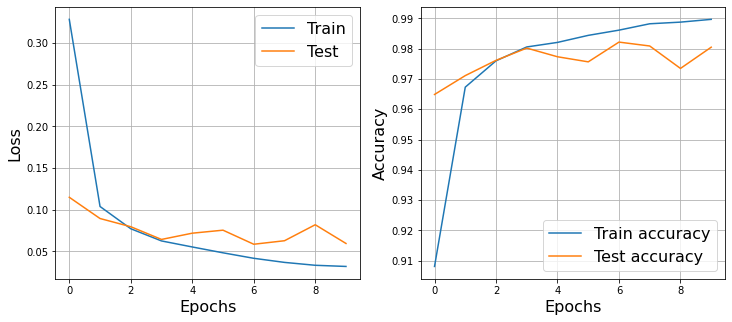

Wall time: 3min 22s


([0.32855616351053407,
  0.10386053118894477,
  0.07713739799140994,
  0.0624998042177258,
  0.05526385635836546,
  0.04823902692756991,
  0.04165548799154378,
  0.03673820754588603,
  0.0332643146666863,
  0.03187103629701022],
 [0.11492774890193456,
  0.08942114641960663,
  0.07957075111850907,
  0.06429875982760251,
  0.07180354787814844,
  0.07540915458156622,
  0.05853343218612143,
  0.06274239056083504,
  0.08194703964775876,
  0.05946355247044865],
 [0.9080602,
  0.9673119,
  0.97601277,
  0.9805937,
  0.9820984,
  0.98442495,
  0.9861519,
  0.9882563,
  0.98880047,
  0.9897166],
 [0.9648932,
  0.9711234,
  0.9761669,
  0.9802215,
  0.97735363,
  0.9756725,
  0.9821994,
  0.98091376,
  0.97349685,
  0.9805182])

In [22]:
%%time
layers1 = build_layers_nrm("layer")
network = TestNetwork(nn.Sequential(*layers1))
train(network, train_loader, test_loader, 10, 0.001, device='cpu')

<i> 3.3 Сделайте выводы по третьей части </i>

Применение layer normalization и batch normalization позволило ускорить сходимость (результаты за первую эпоху гораздо лучше, чем у моделей без них). При этом итоговые показатели лучше у batch normalization.

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: